# Import

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# EDA

In [ ]:
raw = pd.read_csv('predict_yn_satisfaction.csv')

In [ ]:
df = raw.copy()

## 정리

In [ ]:
X = df.copy()
y = df['target']

In [ ]:
X = X.drop(['MB_IDX', 'before_audience'], axis=1)

In [ ]:
X = X[X.columns[:-11]]

In [ ]:
X.head()

,date,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,before_ticket_satisfaction,before_gate_satisfaction,before_seat_satisfaction,...,before_goal_diff,before_game_result,before_rank,youtube_count,youtube_mean_view,youtube_mean_like,age_group,region,job,favorite_idx
0,2022-09-02,1인 테이블석,1,0,없음,0,2,5,5,5,...,2,1.0,3,6,3936,163,30,인천광역시,회사원(사무직/연구직),김보섭
1,2022-04-10,1인 테이블석,1,1,멤버십,0,1,5,1,5,...,0,0.5,2,3,2254,113,20,수도권,서비스업 종사자,오반석
2,2022-02-26,1인 테이블석,1,0,없음,1,4,5,5,5,...,1,1.0,2,4,2794,158,30,인천광역시,자영업자,여름
3,2022-03-05,1인 테이블석,1,0,없음,0,2,5,5,5,...,0,0.5,4,4,1816,97,40,인천광역시,회사원(사무직/연구직),델브리지
4,2022-03-13,1인 테이블석,1,0,없음,0,2,5,5,5,...,-1,0.0,4,4,1046,54,40,인천광역시,회사원(사무직/연구직),델브리지


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        2213 non-null   object 
 1   before_product_grade        2213 non-null   object 
 2   before_special_seat_yn      2213 non-null   int64  
 3   before_discount_yn          2213 non-null   int64  
 4   before_discount_way         2213 non-null   object 
 5   before_first_yn             2213 non-null   int64  
 6   before_reserve_count        2213 non-null   int64  
 7   before_ticket_satisfaction  2213 non-null   int64  
 8   before_gate_satisfaction    2213 non-null   int64  
 9   before_seat_satisfaction    2213 non-null   int64  
 10  weekend_yn                  2213 non-null   int64  
 11  night_yn                    2213 non-null   int64  
 12  final_yn                    2213 non-null   int64  
 13  away_team_name              2213 

In [ ]:
X.isna().sum()

date                            0
before_product_grade            0
before_special_seat_yn          0
before_discount_yn              0
before_discount_way             0
before_first_yn                 0
before_reserve_count            0
before_ticket_satisfaction      0
before_gate_satisfaction        0
before_seat_satisfaction        0
weekend_yn                      0
night_yn                        0
final_yn                        0
away_team_name                  0
before_home_goal                0
before_goal_diff                0
before_game_result              0
before_rank                     0
youtube_count                   0
youtube_mean_view               0
youtube_mean_like               0
age_group                       0
region                          0
job                           107
favorite_idx                    0
dtype: int64

In [ ]:
# job에 결측치가 존재함
# job은 age_group과 관련성이 높을 것이므로 age_group별로 가장 많은 비중을 차지하는 job을 할당해주기로 함

In [ ]:
for i in X['age_group'].unique():
    X.loc[X['age_group'] == i, 'job'] = X.loc[X['age_group'] == i, 'job'].fillna(X[X['age_group'] == i]['job'].value_counts().index[0])

In [ ]:
X['date'] = X['date'].str.split('-').str[1].astype(int)
X = X.rename(columns={'date':'month'})

In [ ]:
encoder = OrdinalEncoder()

need_encoding = []
for i in X.columns:
    if type(X.loc[0, i]) == str:
        need_encoding.append(i)

encoded = encoder.fit_transform(X[need_encoding])

In [ ]:
encoded = encoded.astype(int)

In [ ]:
X_encoded = pd.DataFrame(encoded, columns=need_encoding)

In [ ]:
X.loc[:, need_encoding] = X_encoded

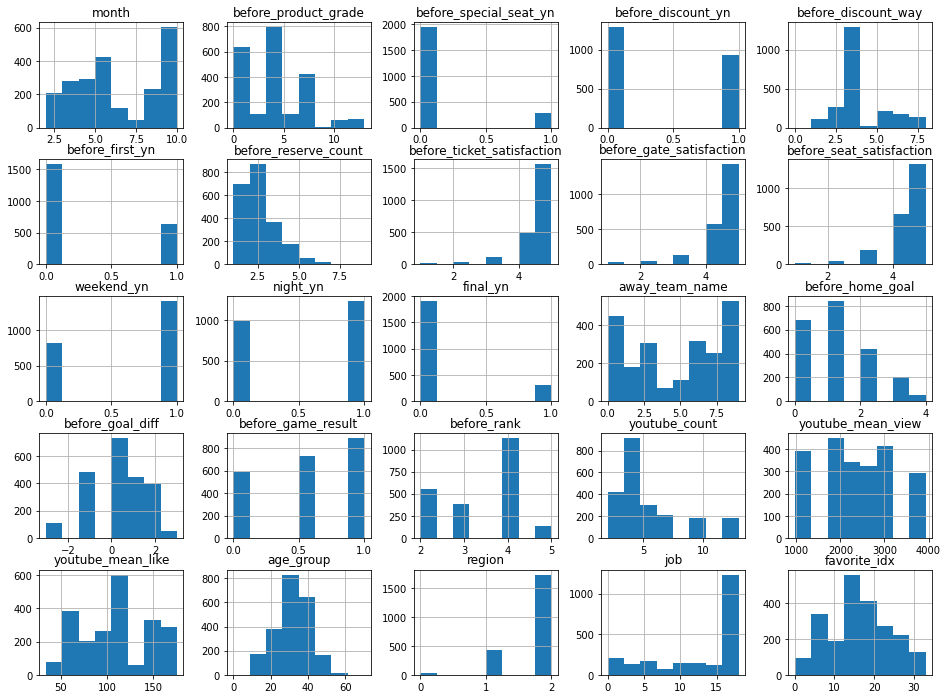

In [ ]:
X.hist(figsize=(16,12), bins=8)
plt.show()

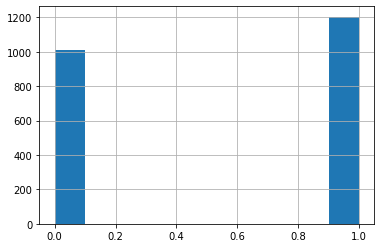

In [ ]:
y.hist()
plt.show()

In [ ]:
# 타겟 균형이 괜찮은 편이라고 생각함

# Feature Select

## 1. 만족도 + 직전 경기 결과 및 순위

In [ ]:
# 일부 피쳐 드랍
X1 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count',
            'youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [ ]:
X1.columns

Index(['month', 'before_ticket_satisfaction', 'before_gate_satisfaction',
       'before_seat_satisfaction', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list1 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.6550059537218805 

classification_report 
               precision    recall  f1-score   support

           0       0.57      0.57      0.57       161
           1       0.64      0.64      0.64       193

    accuracy                           0.61       354
   macro avg       0.60      0.60      0.60       354
weighted avg       0.61      0.61      0.61       354



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7163131979532069 

classification_report 
               precision    recall  f1-score   support

           0       0.64      0.59      0.61       161
           1       0.68      0.73      0.70       193

    accuracy                           0.66       354
   macro avg       0.66      0.66      0.66       354
weighted avg       0.66      0.66      0.66       354



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.6767933575773181 

classification_report 
               precision    recall  f1-score   support

           0       0.60      0.57      0.58       161
           1       0.65      0.68      0.67       193

    accuracy                           0.63       354
   macro avg       0.63      0.62      0.62       354
weighted avg       0.63      0.63      0.63       354



In [ ]:
print('RandomForestClassifier :', score_list1[0])
print('XGBClassifier :', score_list1[1])
print('LGBMClassifier :', score_list1[2])

RandomForestClassifier : 0.6550059537218805
XGBClassifier : 0.7163131979532069
LGBMClassifier : 0.6767933575773181


## 2. 만족도 + 직전 경기 결과 및 순위 + 유튜브

In [ ]:
# 일부 피쳐 드랍
X2 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count'], axis=1)

In [ ]:
X2.columns

Index(['month', 'before_ticket_satisfaction', 'before_gate_satisfaction',
       'before_seat_satisfaction', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'youtube_count',
       'youtube_mean_view', 'youtube_mean_like', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list2 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.6614424098091591 

classification_report 
               precision    recall  f1-score   support

           0       0.61      0.58      0.59       161
           1       0.66      0.68      0.67       193

    accuracy                           0.64       354
   macro avg       0.63      0.63      0.63       354
weighted avg       0.64      0.64      0.64       354



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7139799826215686 

classification_report 
               precision    recall  f1-score   support

           0       0.64      0.60      0.62       161
           1       0.68      0.72      0.70       193

    accuracy                           0.66       354
   macro avg       0.66      0.66      0.66       354
weighted avg       0.66      0.66      0.66       354



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.6743796865445886 

classification_report 
               precision    recall  f1-score   support

           0       0.59      0.58      0.59       161
           1       0.66      0.66      0.66       193

    accuracy                           0.63       354
   macro avg       0.62      0.62      0.62       354
weighted avg       0.63      0.63      0.63       354



In [ ]:
print('RandomForestClassifier :', score_list2[0])
print('XGBClassifier :', score_list2[1])
print('LGBMClassifier :', score_list2[2])

RandomForestClassifier : 0.6614424098091591
XGBClassifier : 0.7139799826215686
LGBMClassifier : 0.6743796865445886


## 3. 만족도 + 직전 경기 결과 및 순위 + 직전 예매 특성

In [ ]:
# 일부 피쳐 드랍
X3 = X.drop(['youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [ ]:
X3.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'before_ticket_satisfaction',
       'before_gate_satisfaction', 'before_seat_satisfaction', 'weekend_yn',
       'night_yn', 'final_yn', 'away_team_name', 'before_home_goal',
       'before_goal_diff', 'before_game_result', 'before_rank', 'age_group',
       'region', 'job', 'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list3 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7314066874778746 

classification_report 
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       161
           1       0.69      0.67      0.68       193

    accuracy                           0.66       354
   macro avg       0.66      0.66      0.66       354
weighted avg       0.66      0.66      0.66       354



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7660991857883049 

classification_report 
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       161
           1       0.76      0.77      0.76       193

    accuracy                           0.74       354
   macro avg       0.74      0.74      0.74       354
weighted avg       0.74      0.74      0.74       354



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7422199337045023 

classification_report 
               precision    recall  f1-score   support

           0       0.64      0.65      0.64       161
           1       0.70      0.69      0.70       193

    accuracy                           0.67       354
   macro avg       0.67      0.67      0.67       354
weighted avg       0.67      0.67      0.67       354



In [ ]:
print('RandomForestClassifier :', score_list3[0])
print('XGBClassifier :', score_list3[1])
print('LGBMClassifier :', score_list3[2])

RandomForestClassifier : 0.7314066874778746
XGBClassifier : 0.7660991857883049
LGBMClassifier : 0.7422199337045023


## 4. 만족도 + 직전 경기 결과 및 순위 + 직전 예매 특성 + 유튜브

In [ ]:
# 일부 피쳐 드랍
X4 = X.copy()

In [ ]:
X4.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'before_ticket_satisfaction',
       'before_gate_satisfaction', 'before_seat_satisfaction', 'weekend_yn',
       'night_yn', 'final_yn', 'away_team_name', 'before_home_goal',
       'before_goal_diff', 'before_game_result', 'before_rank',
       'youtube_count', 'youtube_mean_view', 'youtube_mean_like', 'age_group',
       'region', 'job', 'favorite_idx'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
score_list4 = []

In [ ]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, rfc_prob))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7253886010362695 

classification_report 
               precision    recall  f1-score   support

           0       0.64      0.63      0.63       161
           1       0.69      0.70      0.70       193

    accuracy                           0.67       354
   macro avg       0.66      0.66      0.66       354
weighted avg       0.67      0.67      0.67       354



In [ ]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, xgc_prob))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7629935957261932 

classification_report 
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       161
           1       0.76      0.77      0.76       193

    accuracy                           0.74       354
   macro avg       0.74      0.73      0.73       354
weighted avg       0.74      0.74      0.74       354



In [ ]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, lgc_prob))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7292826569690729 

classification_report 
               precision    recall  f1-score   support

           0       0.65      0.65      0.65       161
           1       0.71      0.70      0.71       193

    accuracy                           0.68       354
   macro avg       0.68      0.68      0.68       354
weighted avg       0.68      0.68      0.68       354



In [ ]:
print('RandomForestClassifier :', score_list4[0])
print('XGBClassifier :', score_list4[1])
print('LGBMClassifier :', score_list4[2])

RandomForestClassifier : 0.7253886010362695
XGBClassifier : 0.7629935957261932
LGBMClassifier : 0.7292826569690729


## 스코어 비교

In [ ]:
print(sum(score_list1)/3)
print(sum(score_list2)/3)
print(sum(score_list3)/3)
print(sum(score_list4)/3)

0.6827041697508017
0.6832673596584389
0.7465752689902274
0.7392216179105118


In [ ]:
print(score_list1)
print(score_list2)
print(score_list3)
print(score_list4)

[0.6550059537218805, 0.7163131979532069, 0.6767933575773181]
[0.6614424098091591, 0.7139799826215686, 0.6743796865445886]
[0.7314066874778746, 0.7660991857883049, 0.7422199337045023]
[0.7253886010362695, 0.7629935957261932, 0.7292826569690729]


In [ ]:
# 3. 만족도 + 직전 경기 결과 및 순위 + 직전 예매 특성 변수일 때, xgboost의 성능이 가장 좋다.

# Hyper Parameter Tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [ ]:
def objective(trial):
  param = {
      "random_state" : 2,
      "objective" : "binary:logistic",
      "eval_metric" : "auc",
      "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 100, 2000),
      "max_depth":trial.suggest_int("max_depth", 4, 10),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
      "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
      "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
  }

  xgc = XGBClassifier(**param)
  xgc.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val,y_val)],
          early_stopping_rounds=100,
          verbose=100)
  xgc_prob = xgc.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, xgc_prob)

  return roc_auc

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'xgc_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-14 20:27:03,046] A new study created in memory with name: xgc_parameter_opt


[0]	validation_0-auc:0.89228	validation_1-auc:0.638963
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999996	validation_1-auc:0.72098
Stopping. Best iteration:
[62]	validation_0-auc:0.999727	validation_1-auc:0.728285



[I 2023-02-14 20:27:04,191] Trial 0 finished with value: 0.7282850062755447 and parameters: {'learning_rate': 0.11861663446573512, 'n_estimators': 1907, 'max_depth': 9, 'colsample_bytree': 0.759195090518222, 'scale_pos_weight': 2.0921304830970557, 'reg_lambda': 0.16443457513284063, 'reg_alpha': 0.06750277604651747, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.7282850062755447.


[0]	validation_0-auc:0.73102	validation_1-auc:0.690069
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.952414	validation_1-auc:0.702153
Stopping. Best iteration:
[19]	validation_0-auc:0.84284	validation_1-auc:0.731889



[I 2023-02-14 20:27:04,869] Trial 1 finished with value: 0.7318894216844205 and parameters: {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}. Best is trial 1 with value: 0.7318894216844205.


[0]	validation_0-auc:0.790348	validation_1-auc:0.700512
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.993141	validation_1-auc:0.731761
Stopping. Best iteration:
[52]	validation_0-auc:0.967872	validation_1-auc:0.74444



[I 2023-02-14 20:27:05,999] Trial 2 finished with value: 0.7444405110546133 and parameters: {'learning_rate': 0.09823025045826593, 'n_estimators': 1097, 'max_depth': 7, 'colsample_bytree': 0.5747374841188252, 'scale_pos_weight': 5.282970263056656, 'reg_lambda': 0.14809892204552141, 'reg_alpha': 0.29922320204986597, 'subsample': 0.6831809216468459}. Best is trial 2 with value: 0.7444405110546133.


[0]	validation_0-auc:0.768704	validation_1-auc:0.718582
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.973718	validation_1-auc:0.741126
Stopping. Best iteration:
[49]	validation_0-auc:0.924804	validation_1-auc:0.747337



[I 2023-02-14 20:27:07,469] Trial 3 finished with value: 0.7473369162938885 and parameters: {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}. Best is trial 3 with value: 0.7473369162938885.


[0]	validation_0-auc:0.830339	validation_1-auc:0.643404
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.989062	validation_1-auc:0.740321
[200]	validation_0-auc:0.999308	validation_1-auc:0.740032
Stopping. Best iteration:
[105]	validation_0-auc:0.989771	validation_1-auc:0.742445



[I 2023-02-14 20:27:10,779] Trial 4 finished with value: 0.7424452096675571 and parameters: {'learning_rate': 0.02886496196573106, 'n_estimators': 1903, 'max_depth': 10, 'colsample_bytree': 0.8850384088698766, 'scale_pos_weight': 3.132296384213595, 'reg_lambda': 0.10669539286632003, 'reg_alpha': 0.6873906962470353, 'subsample': 0.7200762468698007}. Best is trial 3 with value: 0.7473369162938885.


[0]	validation_0-auc:0.755847	validation_1-auc:0.6906
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.876791	validation_1-auc:0.753741
[200]	validation_0-auc:0.922544	validation_1-auc:0.758697
Stopping. Best iteration:
[167]	validation_0-auc:0.909967	validation_1-auc:0.759631



[I 2023-02-14 20:27:11,943] Trial 5 finished with value: 0.7596305474205902 and parameters: {'learning_rate': 0.045391088104985856, 'n_estimators': 1041, 'max_depth': 4, 'colsample_bytree': 0.9455922412472693, 'scale_pos_weight': 2.8114598712001184, 'reg_lambda': 0.6658970615104421, 'reg_alpha': 0.31859396532851686, 'subsample': 0.7600340105889054}. Best is trial 5 with value: 0.7596305474205902.


[0]	validation_0-auc:0.751735	validation_1-auc:0.703939
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:1	validation_1-auc:0.710295
Stopping. Best iteration:
[16]	validation_0-auc:0.981113	validation_1-auc:0.713224



[I 2023-02-14 20:27:13,056] Trial 6 finished with value: 0.7132236990313133 and parameters: {'learning_rate': 0.1685459810095511, 'n_estimators': 451, 'max_depth': 10, 'colsample_bytree': 0.8650796940166687, 'scale_pos_weight': 7.576492590949324, 'reg_lambda': 0.8958790769233723, 'reg_alpha': 0.6019209790229743, 'subsample': 0.9609371175115584}. Best is trial 5 with value: 0.7596305474205902.


[0]	validation_0-auc:0.742865	validation_1-auc:0.703891
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.854909	validation_1-auc:0.757861
[200]	validation_0-auc:0.896821	validation_1-auc:0.759502
Stopping. Best iteration:
[159]	validation_0-auc:0.882062	validation_1-auc:0.761014



[I 2023-02-14 20:27:14,043] Trial 7 finished with value: 0.7610143854793551 and parameters: {'learning_rate': 0.03566282559505665, 'n_estimators': 472, 'max_depth': 4, 'colsample_bytree': 0.5951981984579586, 'scale_pos_weight': 3.720741027826374, 'reg_lambda': 0.27863554145615693, 'reg_alpha': 0.83045013406041, 'subsample': 0.6783766633467947}. Best is trial 7 with value: 0.7610143854793551.


[0]	validation_0-auc:0.747721	validation_1-auc:0.702378
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.904487	validation_1-auc:0.759148
Stopping. Best iteration:
[58]	validation_0-auc:0.870391	validation_1-auc:0.765488



[I 2023-02-14 20:27:14,890] Trial 8 finished with value: 0.7654877224600135 and parameters: {'learning_rate': 0.09147100780934041, 'n_estimators': 1131, 'max_depth': 4, 'colsample_bytree': 0.8813181884524238, 'scale_pos_weight': 1.5218545057583959, 'reg_lambda': 0.9870180672345121, 'reg_alpha': 0.7745223216036908, 'subsample': 0.5993578407670862}. Best is trial 8 with value: 0.7654877224600135.


[0]	validation_0-auc:0.789343	validation_1-auc:0.712001
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.932029	validation_1-auc:0.732082
[200]	validation_0-auc:0.954618	validation_1-auc:0.735912
[300]	validation_0-auc:0.972311	validation_1-auc:0.74193
[400]	validation_0-auc:0.984152	validation_1-auc:0.743861
Stopping. Best iteration:
[333]	validation_0-auc:0.977311	validation_1-auc:0.744634



[I 2023-02-14 20:27:18,191] Trial 9 finished with value: 0.7446336047372317 and parameters: {'learning_rate': 0.011601413965844696, 'n_estimators': 1650, 'max_depth': 8, 'colsample_bytree': 0.8374043008245924, 'scale_pos_weight': 6.39889242680162, 'reg_lambda': 0.08330420521674946, 'reg_alpha': 0.3648810712588299, 'subsample': 0.5579345297625649}. Best is trial 8 with value: 0.7654877224600135.


[0]	validation_0-auc:0.748619	validation_1-auc:0.707624
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.975978	validation_1-auc:0.733659
[110]	validation_0-auc:0.977886	validation_1-auc:0.741287


[I 2023-02-14 20:27:18,932] Trial 10 finished with value: 0.7768158851736234 and parameters: {'learning_rate': 0.2580018906030962, 'n_estimators': 111, 'max_depth': 6, 'colsample_bytree': 0.4107771253688918, 'scale_pos_weight': 1.1019690548376708, 'reg_lambda': 0.9085881473296924, 'reg_alpha': 0.9661419160789868, 'subsample': 0.5064405747517824}. Best is trial 10 with value: 0.7768158851736234.


[0]	validation_0-auc:0.749641	validation_1-auc:0.706996
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.97318	validation_1-auc:0.736331
[111]	validation_0-auc:0.975628	validation_1-auc:0.741962


[I 2023-02-14 20:27:20,150] Trial 11 finished with value: 0.7710874392559457 and parameters: {'learning_rate': 0.27084970441979556, 'n_estimators': 112, 'max_depth': 6, 'colsample_bytree': 0.4103116901613753, 'scale_pos_weight': 1.1646034291831906, 'reg_lambda': 0.9956382388105924, 'reg_alpha': 0.9924246086336254, 'subsample': 0.5054716326541555}. Best is trial 10 with value: 0.7768158851736234.


[0]	validation_0-auc:0.74016	validation_1-auc:0.722669
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.974034	validation_1-auc:0.724262
[113]	validation_0-auc:0.978049	validation_1-auc:0.728639


[I 2023-02-14 20:27:21,710] Trial 12 finished with value: 0.7712805329385641 and parameters: {'learning_rate': 0.27713177310227033, 'n_estimators': 114, 'max_depth': 6, 'colsample_bytree': 0.4021844471848666, 'scale_pos_weight': 1.3145829382817795, 'reg_lambda': 0.7929274402390659, 'reg_alpha': 0.9971929688433538, 'subsample': 0.5227498637885779}. Best is trial 10 with value: 0.7768158851736234.


[0]	validation_0-auc:0.736544	validation_1-auc:0.676488
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.981631	validation_1-auc:0.716603
Stopping. Best iteration:
[16]	validation_0-auc:0.880328	validation_1-auc:0.758134



[I 2023-02-14 20:27:22,583] Trial 13 finished with value: 0.758134071380298 and parameters: {'learning_rate': 0.2968625321171806, 'n_estimators': 163, 'max_depth': 6, 'colsample_bytree': 0.40582958635713684, 'scale_pos_weight': 2.0918693360473815, 'reg_lambda': 0.7853192030826716, 'reg_alpha': 0.9993688142551356, 'subsample': 0.5022590635609818}. Best is trial 10 with value: 0.7768158851736234.


[0]	validation_0-auc:0.757158	validation_1-auc:0.706031
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.980152	validation_1-auc:0.754095
Stopping. Best iteration:
[25]	validation_0-auc:0.901979	validation_1-auc:0.781064



[I 2023-02-14 20:27:23,310] Trial 14 finished with value: 0.7810639461912271 and parameters: {'learning_rate': 0.23527710607670124, 'n_estimators': 559, 'max_depth': 6, 'colsample_bytree': 0.4880490299944742, 'scale_pos_weight': 1.091982210024657, 'reg_lambda': 0.6732237738899947, 'reg_alpha': 0.8673809714469445, 'subsample': 0.5015623345988715}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.773193	validation_1-auc:0.716555
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.997636	validation_1-auc:0.719692
Stopping. Best iteration:
[1]	validation_0-auc:0.810921	validation_1-auc:0.747787



[I 2023-02-14 20:27:23,927] Trial 15 finished with value: 0.7477874682199981 and parameters: {'learning_rate': 0.2299556907973535, 'n_estimators': 615, 'max_depth': 7, 'colsample_bytree': 0.49933376883122665, 'scale_pos_weight': 2.332242330153563, 'reg_lambda': 0.497385637781703, 'reg_alpha': 0.8463861924842628, 'subsample': 0.643954649732532}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.772259	validation_1-auc:0.737682
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.99539	validation_1-auc:0.73131
Stopping. Best iteration:
[9]	validation_0-auc:0.88293	validation_1-auc:0.765826



[I 2023-02-14 20:27:24,685] Trial 16 finished with value: 0.7658256364045957 and parameters: {'learning_rate': 0.22025817179618218, 'n_estimators': 754, 'max_depth': 8, 'colsample_bytree': 0.5016578976407526, 'scale_pos_weight': 1.0370631620715065, 'reg_lambda': 0.6035068198743504, 'reg_alpha': 0.8713091830237861, 'subsample': 0.5512125924693408}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.761462	validation_1-auc:0.728076
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.981895	validation_1-auc:0.742252
Stopping. Best iteration:
[25]	validation_0-auc:0.892391	validation_1-auc:0.760918



[I 2023-02-14 20:27:25,506] Trial 17 finished with value: 0.760917838638046 and parameters: {'learning_rate': 0.23401127045103198, 'n_estimators': 386, 'max_depth': 5, 'colsample_bytree': 0.6108574577180323, 'scale_pos_weight': 3.5627120425361087, 'reg_lambda': 0.8127886689160082, 'reg_alpha': 0.5268251911475419, 'subsample': 0.504513625970024}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.757914	validation_1-auc:0.719725
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.997754	validation_1-auc:0.716313
Stopping. Best iteration:
[3]	validation_0-auc:0.835194	validation_1-auc:0.749767



[I 2023-02-14 20:27:26,254] Trial 18 finished with value: 0.7497666784668362 and parameters: {'learning_rate': 0.19129676301736342, 'n_estimators': 850, 'max_depth': 7, 'colsample_bytree': 0.48478111546891794, 'scale_pos_weight': 4.052698835005961, 'reg_lambda': 0.452558406900367, 'reg_alpha': 0.7387635003252975, 'subsample': 0.6237043251319232}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.752865	validation_1-auc:0.708284
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.984488	validation_1-auc:0.727834
Stopping. Best iteration:
[19]	validation_0-auc:0.888544	validation_1-auc:0.767612



[I 2023-02-14 20:27:27,152] Trial 19 finished with value: 0.7676117529688153 and parameters: {'learning_rate': 0.25324243649732936, 'n_estimators': 313, 'max_depth': 5, 'colsample_bytree': 0.6596473667082949, 'scale_pos_weight': 2.713253737600193, 'reg_lambda': 0.6614100897939887, 'reg_alpha': 0.8802495194376246, 'subsample': 0.5587683326620567}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.78082	validation_1-auc:0.730618
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999678	validation_1-auc:0.7409
Stopping. Best iteration:
[20]	validation_0-auc:0.955971	validation_1-auc:0.761948



[I 2023-02-14 20:27:28,425] Trial 20 finished with value: 0.7619476716120104 and parameters: {'learning_rate': 0.21030440663909294, 'n_estimators': 619, 'max_depth': 8, 'colsample_bytree': 0.5389650964047912, 'scale_pos_weight': 1.9547865868002803, 'reg_lambda': 0.8771687137102459, 'reg_alpha': 0.6911481825898464, 'subsample': 0.7712886602730182}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.74083	validation_1-auc:0.708911
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.981864	validation_1-auc:0.72748
Stopping. Best iteration:
[17]	validation_0-auc:0.884054	validation_1-auc:0.766807



[I 2023-02-14 20:27:29,065] Trial 21 finished with value: 0.7668071959579055 and parameters: {'learning_rate': 0.29976913643139785, 'n_estimators': 213, 'max_depth': 6, 'colsample_bytree': 0.4484251989533564, 'scale_pos_weight': 1.1101532817500819, 'reg_lambda': 0.7437632898169699, 'reg_alpha': 0.9489982588210707, 'subsample': 0.5274089597760899}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.74602	validation_1-auc:0.723828
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.979963	validation_1-auc:0.741126
Stopping. Best iteration:
[17]	validation_0-auc:0.875977	validation_1-auc:0.775191



[I 2023-02-14 20:27:29,613] Trial 22 finished with value: 0.7751906800115855 and parameters: {'learning_rate': 0.2611633621693896, 'n_estimators': 286, 'max_depth': 6, 'colsample_bytree': 0.400226163683959, 'scale_pos_weight': 1.6513619665784312, 'reg_lambda': 0.8782538620269951, 'reg_alpha': 0.9326456108253918, 'subsample': 0.5367551552842366}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.747485	validation_1-auc:0.713674
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.973342	validation_1-auc:0.730312
Stopping. Best iteration:
[3]	validation_0-auc:0.805683	validation_1-auc:0.767773



[I 2023-02-14 20:27:30,121] Trial 23 finished with value: 0.7677726643709973 and parameters: {'learning_rate': 0.25562122479112653, 'n_estimators': 327, 'max_depth': 5, 'colsample_bytree': 0.45536802970967816, 'scale_pos_weight': 1.7506719672390285, 'reg_lambda': 0.9291870170592879, 'reg_alpha': 0.8894694131195977, 'subsample': 0.557592197009742}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.765593	validation_1-auc:0.718679
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.997897	validation_1-auc:0.715637
Stopping. Best iteration:
[10]	validation_0-auc:0.892869	validation_1-auc:0.747417



[I 2023-02-14 20:27:30,779] Trial 24 finished with value: 0.7474173719949795 and parameters: {'learning_rate': 0.24552969069012817, 'n_estimators': 574, 'max_depth': 7, 'colsample_bytree': 0.5325089380455869, 'scale_pos_weight': 1.808055448647198, 'reg_lambda': 0.8605906091403831, 'reg_alpha': 0.8004496822983698, 'subsample': 0.6026522248391801}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.760218	validation_1-auc:0.695894
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.980966	validation_1-auc:0.736685
Stopping. Best iteration:
[10]	validation_0-auc:0.852991	validation_1-auc:0.756782



[I 2023-02-14 20:27:31,543] Trial 25 finished with value: 0.7567824156019695 and parameters: {'learning_rate': 0.20306615404611705, 'n_estimators': 787, 'max_depth': 6, 'colsample_bytree': 0.4555883538099051, 'scale_pos_weight': 2.454806878996972, 'reg_lambda': 0.7258833988194653, 'reg_alpha': 0.9174134757383411, 'subsample': 0.5005173023256747}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.740034	validation_1-auc:0.672626
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.973077	validation_1-auc:0.738776
Stopping. Best iteration:
[11]	validation_0-auc:0.856856	validation_1-auc:0.769591



[I 2023-02-14 20:27:31,848] Trial 26 finished with value: 0.7695909632156536 and parameters: {'learning_rate': 0.2731833300941118, 'n_estimators': 284, 'max_depth': 5, 'colsample_bytree': 0.44520669762440496, 'scale_pos_weight': 1.4474751744460739, 'reg_lambda': 0.9237013205209902, 'reg_alpha': 0.9253013929944593, 'subsample': 0.6426344250546621}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.771271	validation_1-auc:0.739613
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.991406	validation_1-auc:0.734947
Stopping. Best iteration:
[9]	validation_0-auc:0.874016	validation_1-auc:0.776044



[I 2023-02-14 20:27:32,246] Trial 27 finished with value: 0.7760435104431499 and parameters: {'learning_rate': 0.22388290719357695, 'n_estimators': 936, 'max_depth': 7, 'colsample_bytree': 0.52679656397218, 'scale_pos_weight': 1.0026430497450634, 'reg_lambda': 0.8150438119198407, 'reg_alpha': 0.789161612565459, 'subsample': 0.5443848179534928}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.779968	validation_1-auc:0.712355
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998524	validation_1-auc:0.741898
Stopping. Best iteration:
[26]	validation_0-auc:0.947192	validation_1-auc:0.75107



[I 2023-02-14 20:27:32,866] Trial 28 finished with value: 0.75107006082451 and parameters: {'learning_rate': 0.22536187899025514, 'n_estimators': 921, 'max_depth': 7, 'colsample_bytree': 0.5464782150985692, 'scale_pos_weight': 3.0244325498938873, 'reg_lambda': 0.5619424750570794, 'reg_alpha': 0.7809000012673403, 'subsample': 0.5705598071749469}. Best is trial 14 with value: 0.7810639461912271.


[0]	validation_0-auc:0.797071	validation_1-auc:0.683922
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999932	validation_1-auc:0.734786
Stopping. Best iteration:
[27]	validation_0-auc:0.979879	validation_1-auc:0.746532



[I 2023-02-14 20:27:33,595] Trial 29 finished with value: 0.7465323592829788 and parameters: {'learning_rate': 0.20672381767250483, 'n_estimators': 1240, 'max_depth': 8, 'colsample_bytree': 0.6328225133603802, 'scale_pos_weight': 2.2839977886306713, 'reg_lambda': 0.7253630494945367, 'reg_alpha': 0.8169379969846826, 'subsample': 0.831653832248192}. Best is trial 14 with value: 0.7810639461912271.


Best Score: 0.7810639461912271
Best trial {'learning_rate': 0.23527710607670124, 'n_estimators': 559, 'max_depth': 6, 'colsample_bytree': 0.4880490299944742, 'scale_pos_weight': 1.091982210024657, 'reg_lambda': 0.6732237738899947, 'reg_alpha': 0.8673809714469445, 'subsample': 0.5015623345988715}


In [ ]:
params = study.best_params

params["random_state"] = 2
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

In [ ]:
xgc = XGBClassifier(**params)

xgc.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val,y_val)],
        early_stopping_rounds=100,
        verbose=100)

[0]	validation_0-auc:0.757158	validation_1-auc:0.706031
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.980152	validation_1-auc:0.754095
Stopping. Best iteration:
[25]	validation_0-auc:0.901979	validation_1-auc:0.781064



XGBClassifier(colsample_bytree=0.4880490299944742, eval_metric='auc',
              learning_rate=0.23527710607670124, max_depth=6, n_estimators=559,
              random_state=2, reg_alpha=0.8673809714469445,
              reg_lambda=0.6732237738899947, scale_pos_weight=1.091982210024657,
              subsample=0.5015623345988715)

In [ ]:
xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

print('XGBClassifier_val')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier_val
roc_auc_score : 0.7810639461912271 

classification_report 
               precision    recall  f1-score   support

           0       0.69      0.70      0.69       161
           1       0.74      0.74      0.74       193

    accuracy                           0.72       354
   macro avg       0.72      0.72      0.72       354
weighted avg       0.72      0.72      0.72       354



In [ ]:
xgc_pred = xgc.predict(X_test)
xgc_prob = xgc.predict_proba(X_test)[:,1]

print('XGCClassifier_test')
print('roc_auc_score :', roc_auc_score(y_test, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_test, xgc_pred))

XGCClassifier_test
roc_auc_score : 0.731615381455158 

classification_report 
               precision    recall  f1-score   support

           0       0.65      0.64      0.65       202
           1       0.70      0.72      0.71       241

    accuracy                           0.68       443
   macro avg       0.68      0.68      0.68       443
weighted avg       0.68      0.68      0.68       443



In [ ]:
feature_importance = pd.DataFrame([X_test.columns, xgc.feature_importances_]).T.rename(columns={0:'features',1:'importance'}).sort_values('importance', ascending=False).reset_index(drop=True)

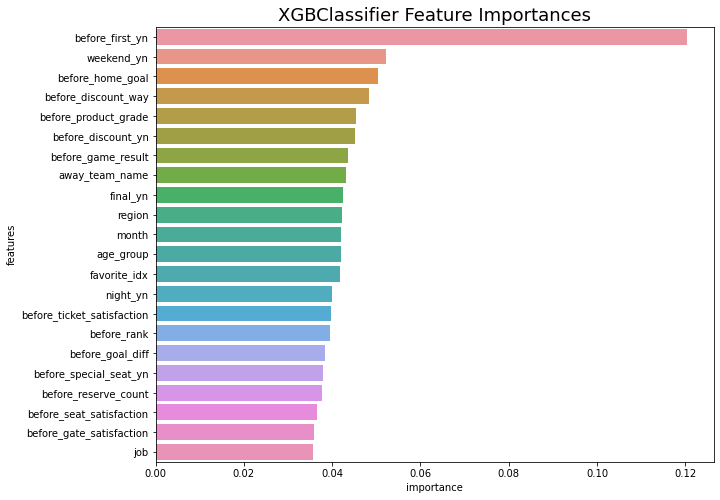

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='features', data=feature_importance)
plt.title('XGBClassifier Feature Importances', fontsize=18)
plt.show()

In [ ]:
df[['MB_IDX','date']] = raw[['MB_IDX','date']]

In [ ]:
df.head()

,date,MB_IDX,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,before_ticket_satisfaction,before_gate_satisfaction,...,total_special_seat,total_reserve_date,total_reserve_ticket,rate_ticket_discount,rate_special_seat,mean_reserve_ticket,mean_game_nth_diff,last_game_nth,cluster,target
0,2022-09-02,121255,1인 테이블석,1,0,없음,0,2,5,5,...,6,5,10,0.20,0.60,2.00,1.50,19,3,0
1,2022-04-10,136710,1인 테이블석,1,1,멤버십,0,1,5,1,...,5,6,10,1.00,0.50,1.67,3.00,19,3,1
2,2022-02-26,141053,1인 테이블석,1,0,없음,1,4,5,5,...,4,11,31,0.00,0.13,2.82,1.80,19,4,1
3,2022-03-05,127881,1인 테이블석,1,0,없음,0,2,5,5,...,12,18,44,0.05,0.27,2.44,1.06,19,5,1
4,2022-03-13,127881,1인 테이블석,1,0,없음,0,2,5,5,...,12,18,44,0.05,0.27,2.44,1.06,19,5,0


In [67]:
df.to_csv('data_analysis3.csv', index=False)